<a href="https://colab.research.google.com/github/K-julius/dl_project/blob/main/Baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import matplotlib.pyplot as plt
import numpy as np

In [23]:
batch_size = 16
epochs = 1

In [24]:
data_path = '/content/drive/MyDrive/DL_project/archive_CGrestored'

transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.ImageFolder(root=os.path.join(data_path, 'train'), transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root=os.path.join(data_path, 'test'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

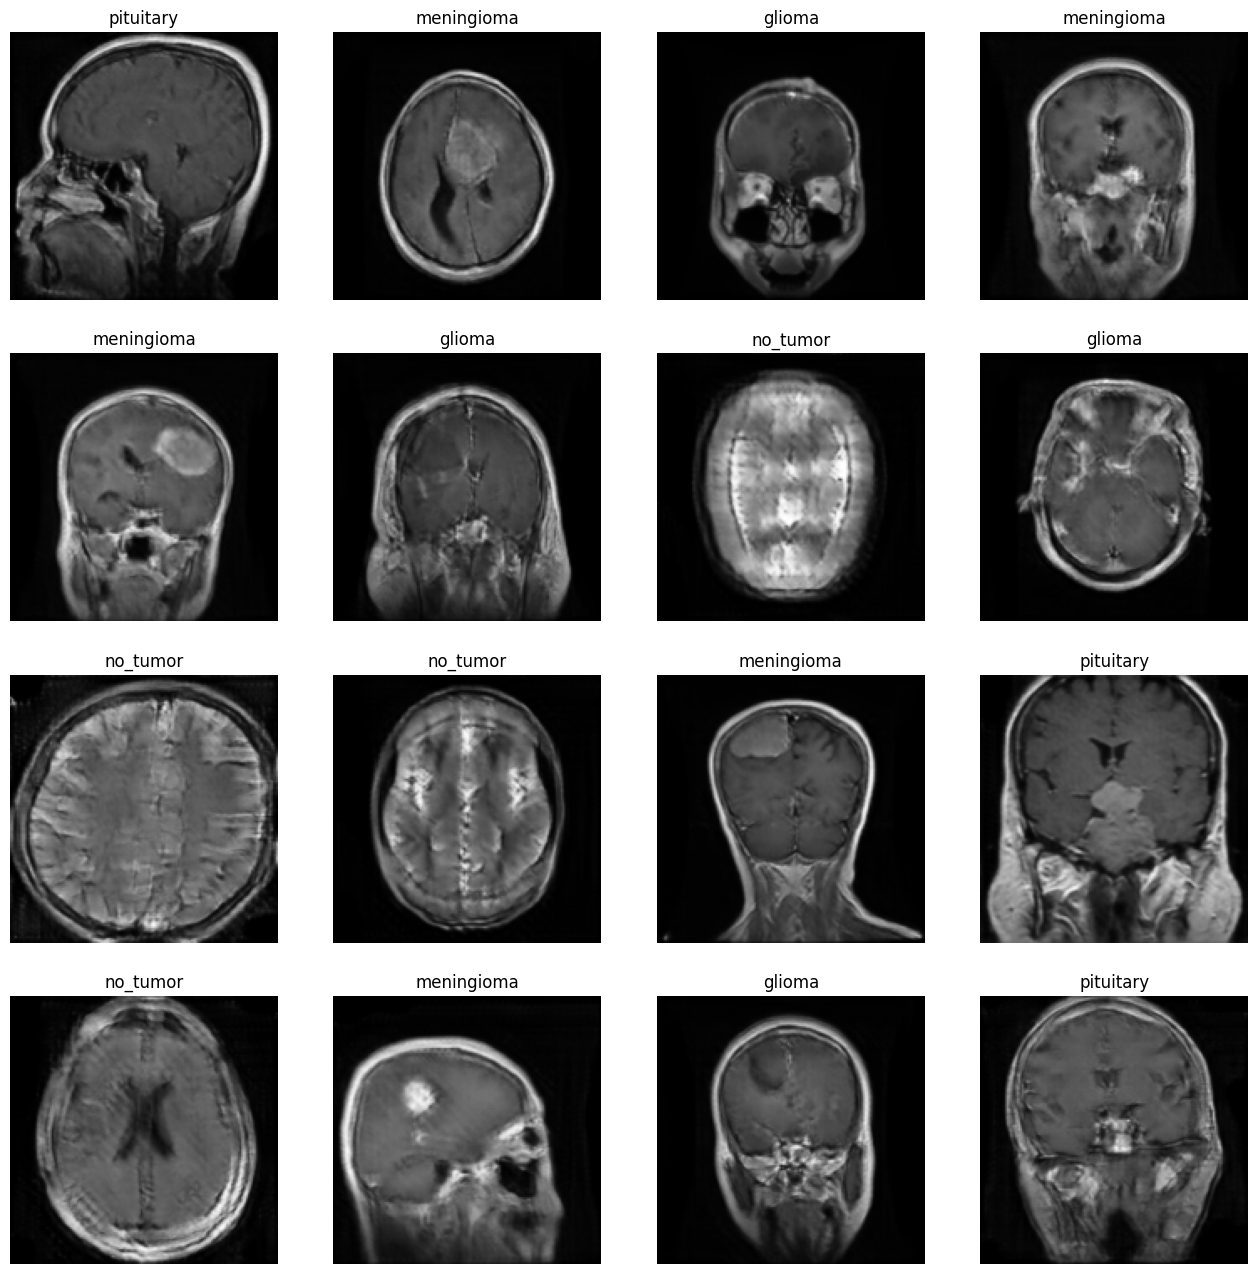

In [39]:
#samples, labels = iter(train_loader).next()
# AttributeError: '_SingleProcessDataLoaderIter' object has no attribute 'next'

samples, labels = next(iter(train_loader))
classes = {0: 'glioma', 1: 'meningioma', 2: 'no_tumor', 3: 'pituitary'}
fig = plt.figure(figsize=(16,16))
for i in range(16):
  ax = fig.add_subplot(4, 4, i+1)
  ax.set_title(classes[labels[i].item()])
  ax.axis('off')
  ax.imshow(samples[i].permute(1, 2, 0))
plt.subplots_adjust()

#IndexError: index 16 is out of bounds for dimension 0 with size 16
#batch_size를 16으로 설정했으므로 16 넘어가는 크기 생성시 오류 발생

Pretrained_model

In [26]:
resnet50 = models.resnet50(pretrained=True)
inception_v3 = models.inception_v3(pretrained=True)
densenet = models.densenet161(pretrained=True)
vgg19 = models.vgg19(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-d

In [27]:
def set_parameter_requires_grad(model, feature_extracting = True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

set_parameter_requires_grad(resnet50)
set_parameter_requires_grad(inception_v3)
set_parameter_requires_grad(densenet)
set_parameter_requires_grad(vgg19)

In [28]:
resnet50.fc = nn.Linear(resnet50.fc.in_features, 4)
inception_v3.fc = nn.Linear(inception_v3.fc.in_features, 4)
densenet.classifier = nn.Linear(densenet.classifier.in_features, 4)
vgg19.classifier[6] = nn.Linear(vgg19.classifier[6].in_features, 4)

In [29]:
# for name, param in resnet50.named_parameters():
#   if param.requires_grad:
#     print(name, param.data)

In [30]:
for param in resnet50.parameters():
  param.requires_grad = False

for param in inception_v3.parameters():
  param.requires_grad = False

for param in densenet.parameters():
  param.requires_grad = False

for param in vgg19.parameters():
  param.requires_grad = False

In [31]:
resnet50.fc = torch.nn.Linear(resnet50.fc.in_features, 4)
inception_v3.fc = torch.nn.Linear(inception_v3.fc.in_features, 4)
densenet.classifier = torch.nn.Linear(densenet.classifier.in_features, 4)
vgg19.classifier[6] = torch.nn.Linear(vgg19.classifier[6].in_features, 4)

In [32]:
for param in resnet50.fc.parameters():
  param.requires_grad = True

for param in inception_v3.fc.parameters():
  param.requires_grad = True

for param in densenet.classifier.parameters():
  param.requires_grad = True

for param in vgg19.classifier[6].parameters():
  param.requires_grad = True

In [33]:
optimizer = optim.Adam(resnet50.fc.parameters())
optimizer = optim.Adam(inception_v3.fc.parameters())
optimizer = optim.Adam(densenet.classifier.parameters())
optimizer = optim.Adam(vgg19.classifier[6].parameters())

cost = nn.CrossEntropyLoss()

In [34]:
def train_model(model, model_name, dataloaders, criterion, optimizer, device, num_epochs=epochs, is_train=True):
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0

    run_dir = '/content/drive/MyDrive/DL_project/runs_noise_removal'
    run_dir = os.path.join(run_dir, model_name) #model_name = "resnet50", "inception_v3", "densenet", "vgg19"

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join(run_dir, '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    return acc_history, loss_history

In [35]:
def eval_model(model, model_name, dataloaders, device):
    since = time.time()
    acc_history = []
    pred_history = []
    label_history = []
    best_acc = 0.0

    run_dir = '/content/drive/MyDrive/DL_project/runs_noise_removal'
    run_dir = os.path.join(run_dir, model_name) #model_name = "resnet50", "inception_v3", "densenet", "vgg19"

    saved_models = glob.glob(run_dir + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            label_history.append(labels) #정답 라벨 저장

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)
            pred_history.append(preds) #예측한 index 저장
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels).int().sum()

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history, label_history, pred_history

1. ResNet50

In [36]:
params_to_update = []
for name,param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet50, "resnet50", train_loader, criterion, optimizer, device)

Epoch 0/0
----------


KeyboardInterrupt: ignored

In [ ]:
val_acc_hist, label_h, pred_h = eval_model(resnet50, "resnet50", test_loader, device)

In [ ]:
print(pred_h[:10])
print(label_h[:10])

In [ ]:
cm = confusion_matrix(pred_h, label_h)

disp = ConfusionMatrixDisplay.from_estimator(
        confusion_matrix = cm,
        display_labels=classes,
        cmap=plt.cm.Blues,
        normalize=None,
    )

disp.ax_.set_title("Confusion Matrix")
print(disp.confusion_matrix)

plt.show()
plt.savefig("confusion_matrix.png")

2. Inception_v3

In [ ]:
params_to_update = []
for name,param in inception_v3.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

optimizer = optim.Adam(params_to_update)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(inception_v3, "inception_v3", train_loader, criterion, optimizer, device)

In [ ]:
val_acc_hist = eval_model(inception_v3, "inception_v3", test_loader, device)

3. DenseNet

In [ ]:
params_to_update = []
for name,param in densenet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

optimizer = optim.Adam(params_to_update)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(densenet, "densenet", train_loader, criterion, optimizer, device)

In [ ]:
val_acc_hist = eval_model(densenet, "densenet", test_loader, device)

4. VGG19

In [ ]:
params_to_update = []
for name,param in vgg19.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

optimizer = optim.Adam(params_to_update)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(vgg19, "vgg19", train_loader, criterion, optimizer, device)

In [ ]:
val_acc_hist = eval_model(vgg19, "vgg19", test_loader, device)